## Analysis of possible RBC subtypes
The code in this notebook analyses differences between the RBCs contacting cones and rods and those contacting only rods in order to find evidence for or against two types of RBCs

In [1]:
import numpy as np
from scipy.stats import itemfreq
from scipy.io import loadmat
from scipy.spatial import ConvexHull
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from PIL import ImageDraw
from sklearn.mixture import GMM
from shapely.geometry import Polygon
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
sns.set_style("whitegrid")

### Import data

In [3]:
cone_contacts=pd.read_pickle('data/cone_contact_predictions')
rod_contacts=pd.read_pickle('data/rod_contact_predictions')
BC_IDs=np.loadtxt('data/BC_IDs_new')
ID_table=np.loadtxt('data/cell_IDs.csv',dtype=int,delimiter=',')
BC_in_rod_area=np.loadtxt('data/BC_in_rod_area')
BC_excluded=np.array([691,709,827,836])

In [4]:
rbc=BC_IDs[(BC_IDs[:,4]>70)&np.in1d(BC_IDs[:,0],BC_in_rod_area)&np.in1d(BC_IDs[:,0],BC_excluded,invert=True),0]

In [5]:
rbc_rod_contacts=rod_contacts.ix[(rod_contacts['prediction']==1)]
rbc_rod_contacts=rbc_rod_contacts[np.in1d(rbc_rod_contacts['cell'],rbc)].reset_index().drop('index',axis=1)

In [6]:
rbc_cone_contacts=cone_contacts.ix[(cone_contacts['prediction']==1)]
rbc_cone_input=np.unique(rbc_cone_contacts[np.in1d(rbc_cone_contacts['cell'],BC_excluded,invert=True)&\
                                           np.in1d(rbc_cone_contacts['cell'],BC_IDs[BC_IDs[:,4]==71,0])]['cell']).astype(int)
rbc_rod_input=BC_IDs[(BC_IDs[:,4]==71)&np.in1d(BC_IDs[:,0],rbc_cone_input,invert=True)&np.in1d(BC_IDs[:,0],BC_excluded,invert=True),0].astype(int)
rbc_cone_contacts=rbc_cone_contacts[np.in1d(rbc_cone_contacts['cell'],rbc)].reset_index().drop('index',axis=1)

In [7]:
#mean(on_sac)=6327, mean(off_sac)=5403
x_start=-5403*(0.62-0.28)/(6327-5403)+0.28
x_end=10000*(0.62-0.28)/(6327-5403)+x_start
x_scale=np.linspace(x_start*100,x_end*100,10000)

In [8]:
skeleton_data=loadmat('data/skeletons_OPL_final.mat')
skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'].flatten()
M=np.loadtxt('data/coordinate_rotation')
soma_data=loadmat('data/soma_positions.mat')
soma_pos=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_allSomata']
soma_internal_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs']
soma_line_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs_pure_forSomata']
soma_pos=np.dot(M,soma_pos[:,:3].T).T
soma_positions=[]
for i in range(BC_IDs.shape[0]):
    soma_positions.append(soma_pos[soma_line_ids[0,np.where(soma_internal_ids==BC_IDs[i,1])[1][0]]-1,:])
soma_positions=np.array(soma_positions)

#### Number of rod contacts (Supp. figure 3B)

In [9]:
stat_bc_contacts=pd.DataFrame(rbc,columns=['cell'])
contact_freq_rbc=itemfreq(rbc_rod_contacts['cell'].as_matrix())
for i in range(stat_bc_contacts.shape[0]):
    stat_bc_contacts.loc[i,'count']=0
    try:
        stat_bc_contacts.ix[i,'count']=contact_freq_rbc[contact_freq_rbc[:,0]==stat_bc_contacts.ix[i,'cell'],1]
    except ValueError:
        continue

In [10]:
for i in range(stat_bc_contacts.shape[0]):
    if stat_bc_contacts.ix[i,'cell'] in np.unique(rbc_cone_contacts['cell']):
        stat_bc_contacts.loc[i,'cone_contacts']=1
    else:
        stat_bc_contacts.loc[i,'cone_contacts']=0

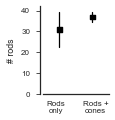

In [11]:
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 0, "ytick.major.size": 4})
with matplotlib.rc_context({"lines.linewidth": 0.7}):
    plt.figure(figsize=(3/2.54,4/2.54))
    ax=sns.pointplot(x='cone_contacts',y='count',data=stat_bc_contacts,ci=95,order=[0,1], \
                     linestyles='',markers='s',scale=1.5,color='black')
    ax.set(ylabel='# rods',ylim=(0,42),yticks=[0,10,20,30,40],xlabel='',xticklabels=['Rods\nonly','Rods +\ncones'],xticks=[-0.1,1.1])
    sns.despine()
    ax.spines['left'].set_position(('outward',3))
#     plt.savefig('figures/rbc_rod_contact_comparison.svg',bbox_inches='tight',dpi=300)
    plt.show()

#### AII connectivity (Supp. figure 3C)

In [12]:
connectivity=loadmat('data/Helmstaedter_et_al_SUPPLinformation5.mat')['kn_allContactData_Interfaces_duplCorr_output_IDconv']

In [13]:
rbc_ids=ID_table[ID_table[:,3]==71,0]
ac_ids=ID_table[ID_table[:,3]==24,0]
rbc_ac_contacts=connectivity[np.in1d(connectivity[:,0],ac_ids)&np.in1d(connectivity[:,1],rbc_ids)]

In [14]:
ac_connectivity=pd.DataFrame(BC_IDs[(BC_IDs[:,4]==71)&np.in1d(BC_IDs[:,0],BC_excluded,invert=True),0],columns=['rbc'])
for i in range(ac_connectivity.shape[0]):
    if ac_connectivity.ix[i,'rbc'] in rbc_cone_input:
        ac_connectivity.loc[i,'cone_input']=1
    else:
        ac_connectivity.loc[i,'cone_input']=0
    ac_connectivity.loc[i,'area']=np.sum(rbc_ac_contacts[rbc_ac_contacts[:,1]==ac_connectivity.ix[i,'rbc'],2])
ac_connectivity=ac_connectivity[ac_connectivity['area']>0].reset_index().drop('index',axis=1)

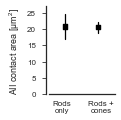

In [15]:
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 0, "ytick.major.size": 4,"mathtext.default":'regular'})
with matplotlib.rc_context({"lines.linewidth": 0.7}):
    plt.figure(figsize=(3/2.54,4/2.54))
#     plt.figure(figsize=(3,4))
    ax=sns.pointplot(x='cone_input',y='area',data=ac_connectivity,ci=95,order=[0,1],\
                     linestyles='',markers='s',scale=1.5,color='black')
    ax.set(ylim=(0,27),yticks=[0,5,10,15,20,25],xlabel='',xticklabels=['Rods\nonly','Rods +\ncones'],xticks=[-0.1,1.1])
    ax.set_ylabel('AII contact area [$\mu m^2$]')
    sns.despine()
    ax.spines['left'].set_position(('outward',3))
#     plt.savefig('figures/rbc_AII_contacts.svg',bbox_inches='tight',dpi=300)
    plt.show()

#### Density from flattened OFF- and ON-SAC (Supp. figure 3A, top)

In [16]:
volume_density=np.loadtxt('data/density_data_BC_flattened.gz')
volume_density=volume_density[:,BC_IDs[:,3]==71]

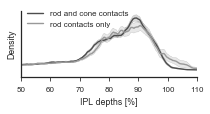

In [17]:
plt.figure(figsize=(8/2.54,3/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 0})
plt.fill_between(x_scale,(np.mean(volume_density[:,rbc_cone_input-697],axis=1)-np.std(volume_density[:,rbc_cone_input-697],axis=1)/np.sqrt(len(rbc_cone_input)-1))\
                 /np.sum(np.mean(volume_density[:,rbc_cone_input-697],axis=1)),\
                 (np.mean(volume_density[:,rbc_cone_input-697],axis=1)+np.std(volume_density[:,rbc_cone_input-697],axis=1)/np.sqrt(len(rbc_cone_input)-1))\
                 /np.sum(np.mean(volume_density[:,rbc_cone_input-697],axis=1)),facecolor='0.5',alpha=0.3)
plt.fill_between(x_scale,(np.mean(volume_density[:,rbc_rod_input-697],axis=1)-np.std(volume_density[:,rbc_rod_input-697],axis=1)/np.sqrt(len(rbc_rod_input)-1))\
                 /np.sum(np.mean(volume_density[:,rbc_rod_input-697],axis=1)),\
                 (np.mean(volume_density[:,rbc_rod_input-697],axis=1)+np.std(volume_density[:,rbc_rod_input-697],axis=1)/np.sqrt(len(rbc_rod_input)-1))\
                 /np.sum(np.mean(volume_density[:,rbc_rod_input-697],axis=1)),facecolor='0.7',alpha=0.3)

plt.plot(x_scale,np.sum(volume_density[:,rbc_cone_input-697],axis=1)/np.sum(volume_density[:,rbc_cone_input-697]),label='rod and cone contacts',c='0.3')
plt.plot(x_scale,np.sum(volume_density[:,rbc_rod_input-697],axis=1)/np.sum(volume_density[:,rbc_rod_input-697]),label='rod contacts only',c='0.6')
plt.xlabel('IPL depths [%]')
plt.ylabel('Density')
plt.yticks([])
plt.xlim(50,110)
sns.despine()
plt.legend(bbox_to_anchor=(0.65, 1.13))
# plt.savefig('figures/rbc_density_comparision.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

#### Density aligned on ON-SAC (Supp. figure 3A, bottom)

In [18]:
rbc_densities=np.loadtxt('data/density_data_RBC_ON_SAC_alignment.gz')

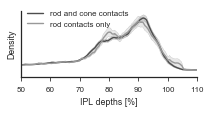

In [19]:
plt.figure(figsize=(8/2.54,3/2.54))
# plt.figure(figsize=(8,3))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 0})
plt.fill_between(x_scale,(np.mean(rbc_densities[:,rbc_cone_input-697],axis=1)-np.std(rbc_densities[:,rbc_cone_input-697],axis=1)/np.sqrt(len(rbc_cone_input)-1))\
                 /np.sum(np.mean(rbc_densities[:,rbc_cone_input-697],axis=1)),\
                 (np.mean(rbc_densities[:,rbc_cone_input-697],axis=1)+np.std(rbc_densities[:,rbc_cone_input-697],axis=1)/np.sqrt(len(rbc_cone_input)-1))\
                 /np.sum(np.mean(rbc_densities[:,rbc_cone_input-697],axis=1)),facecolor='0.5',alpha=0.3)
plt.fill_between(x_scale,(np.mean(rbc_densities[:,rbc_rod_input-697],axis=1)-np.std(rbc_densities[:,rbc_rod_input-697],axis=1)/np.sqrt(len(rbc_rod_input)-1))\
                 /np.sum(np.mean(rbc_densities[:,rbc_rod_input-697],axis=1)),\
                 (np.mean(rbc_densities[:,rbc_rod_input-697],axis=1)+np.std(rbc_densities[:,rbc_rod_input-697],axis=1)/np.sqrt(len(rbc_rod_input)-1))\
                 /np.sum(np.mean(rbc_densities[:,rbc_rod_input-697],axis=1)),facecolor='0.7',alpha=0.3)
plt.plot(x_scale,np.sum(rbc_densities[:,rbc_cone_input-697],axis=1)/np.sum(rbc_densities[:,rbc_cone_input-697]),label='rod and cone contacts',c='0.3')
plt.plot(x_scale,np.sum(rbc_densities[:,rbc_rod_input-697],axis=1)/np.sum(rbc_densities[:,rbc_rod_input-697]),label='rod contacts only',c='0.6')
plt.xlabel('IPL depths [%]')
plt.ylabel('Density')
plt.yticks([])
plt.xlim(50,110)
sns.despine()
plt.legend(bbox_to_anchor=(0.65, 1.13))
# plt.savefig('figures/rbc_density_comparision_on_sac_only.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

#### Plot dendritic fields/axon terminals (Supp. figure 3D)

In [20]:
#Function definition for mosaic plotting
def plot_mosaic(selection,layer='OPL'):
    im=Image.new('RGBA',(4800,3600),(255,255,255,0))
    draw = ImageDraw.Draw(im)
    draw.line([(0,0),(0,3599)],fill=(0,0,255,255),width=1)
    draw.line([(0,3599),(4799,3599)],fill=(0,0,255,255),width=1)
    draw.line([(4799,3599),(4799,0)],fill=(0,0,255,255),width=1)
    draw.line([(4799,0),(0,0)],fill=(0,0,255,255),width=1)
    del draw
    for cell in BC_IDs[selection,0]:
        nodes_cell=np.empty((0,3))
        for skel in np.where(skeleton_ids==cell)[0]:
            nodes=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('nodes')][:,:3]/[16.5,16.5,25]
            if nodes.shape[0]<2:
                continue
            nodes=np.dot(M,nodes.T).T
            edges=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('edges')]
            soma_pos_cell=soma_positions[BC_IDs[:,0]==cell,0]*16.5
            draw = ImageDraw.Draw(im)
            if layer=='OPL':
                nodes=(nodes*[16.5,16.5,25]+[0,3250,15000]).astype(int)
                for i in range(edges.shape[0]):
                    if (nodes[edges[i,0]-1,0]<soma_pos_cell) and (nodes[edges[i,1]-1,0]<soma_pos_cell):
                        draw.line([tuple(nodes[edges[i,0]-1,1:3]/[25,25]),tuple(nodes[edges[i,1]-1,1:3]/[25,25])],fill=(0,0,0,150),width=5)
                del draw
                nodes=nodes[np.unique(edges).astype(int)-1,:]
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]<soma_pos_cell,0:3]),axis=0)
            elif layer=='IPL':
                nodes=(nodes*[16.5,16.5,25]+[0,5000,22750]).astype(int)
                for i in range(edges.shape[0]):
                    if (nodes[edges[i,0]-1,0]>soma_pos_cell) and (nodes[edges[i,1]-1,0]>soma_pos_cell):
                        draw.line([tuple(nodes[edges[i,0]-1,1:3]/[25,25]),tuple(nodes[edges[i,1]-1,1:3]/[25,25])],fill=(0,0,0,150),width=5)
                del draw
                nodes=nodes[np.unique(edges).astype(int)-1,:]
                nodes_cell=np.concatenate((nodes_cell,nodes[nodes[:,0]>soma_pos_cell,0:3]),axis=0)
            else:
                print("Layer has to be 'IPL' or 'OPL'")
                return im
        if nodes_cell.shape[0]>2:
            nodes_cell=nodes_cell[:,1:]/[25,25]
            hull=ConvexHull(nodes_cell)
            draw = ImageDraw.Draw(im)
            for simplex in hull.simplices:
                draw.line([tuple(nodes_cell[simplex[0],:]),tuple(nodes_cell[simplex[1],:])],fill=(0,0,255,255),width=5)
            del draw
    return im

In [ ]:
plot_mosaic(rbc_rod_input-390,'OPL')

In [ ]:
plot_mosaic(rbc_rod_input-390,'IPL')

In [ ]:
plot_mosaic(rbc_cone_input-390,'OPL')

In [ ]:
plot_mosaic(rbc_cone_input-390,'IPL')